## SUITE P5

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dans le Notebook Jupyter nous avons vu l'exploration, ainsi que le prétraitement des données. Ici nous utiliserons un GPU pour effectuer les modélisations.

In [ ]:
#Test de l'activation du GPU
#Si le GPU est activé, il donnera la sortie suivante - '/ device: GPU: 0 '
import tensorflow as tf
tf.test.gpu_device_name ()

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib 
device_lib.list_local_devices ()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17382946947712815594, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16185556992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14075431960778048404
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

### Importation des librairies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
import seaborn as sns
import numpy as np
import pickle
import os
from zipfile import ZipFile
from scipy.cluster.hierarchy import fcluster
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn import decomposition
import plotly.figure_factory as ff
from sklearn import preprocessing
import scipy.cluster.hierarchy as sch

from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import dendrogram, linkage

import time, warnings

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", 101)
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (9,6)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


### Télecharger le fichier de jeu de données

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
z = ZipFile("/content/gdrive/My Drive/Colab Notebooks/input5/data.zip")
data = pd.read_csv(z.open('data.csv'))

data.shape

(96096, 18)

In [ ]:
data.head()

,Unnamed: 0,customer_unique_id,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Date_dernier_achat,Villes,Cat_prod,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Type_paiement,Note_facil_pai_moy,Latitude,Longitude
0,0,0000366f3b9a7992bf8c76cfdf3221e2,66,66,8573.40,129.90,5.0,2018-05-10 10:56:27,cajamar,home,160.0,6.0,10.0,3.0,credit_card,8.0,-23.340235,-46.830140
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,144,144,2721.60,18.90,4.0,2018-05-07 11:11:27,osasco,health_beauty,163.0,3.0,11.0,0.0,credit_card,1.0,-23.559115,-46.787626
2,2,0000f46a3911fa3c0805444483337064,117,117,8073.00,69.00,3.0,2017-03-10 21:05:03,sao jose,office,585.0,25.0,21.0,4.0,credit_card,8.0,-27.542880,-48.633426
3,3,0000f6ccb0745a6a4b88665a16c9f078,32,32,831.68,25.99,4.0,2017-10-12 20:29:41,belem,electronics,369.0,20.0,20.0,3.0,credit_card,4.0,-1.312214,-48.483159
4,4,0004aac84e0df4da2b147fca70cf8255,133,133,23940.00,180.00,5.0,2017-11-14 19:45:42,sorocaba,electronics,336.0,13.0,19.0,1.0,credit_card,6.0,-23.505548,-47.469705


In [ ]:
data = data.drop(['Unnamed: 0'],axis=1)

In [ ]:
dict_categories_1 = {
"credit_card" : "credit_card",
"boleto" : "boleto",
"['credit_card' 'voucher']" : "credit_card",
"debit_card" : "debit_card",
"voucher" : "voucher",
"['boleto' 'credit_card']" : "credit_card",
"['boleto' 'voucher']" : "boleto",
"['credit_card' 'debit_card']" : "credit_card",
"['boleto' 'debit_card']" : "boleto",
"['boleto' 'credit_card' 'voucher']" : "credit_card",
"not_defined" : "credit_card",
"['debit_card' 'voucher']" : "debit_card",
"['credit_card' 'debit_card' 'voucher']" : "credit_card",
"['boleto' 'not_defined']" : "credit_card",
"['boleto' 'credit_card' 'debit_card']" : "credit_card"

}

In [ ]:
data['Type_paiement'] = data['Type_paiement'].map(dict_categories_1)

In [ ]:
dict_categories_2 = {
#domicile
"home" : "home",
"['electronics' 'home']" : "home",
"['health_beauty' 'home']" : "home",
"['sports_leisure' 'home']" : "home",
"['fashion' 'home']" : "home",
"['appliances' 'home']" : "home",
"['garden_pets' 'home']" : "home",
"['arts' 'home']" : "home",
"['office' 'home']" : "home",
"['auto' 'home']" : "home",
"['other' 'home']" : "home",
"['construction' 'home']" : "home",
"['food_drinks' 'home']" : "home",

    
#appareils ménagers
"appliances" : "appliances",
"['garden_pets' 'appliances']" : "appliances",
"['arts' 'appliances']" : "appliances",
"['office' 'appliances']" : "appliances",
"['auto' 'appliances']" : "appliances",
"['other' 'appliances']" : "appliances",
"['construction' 'appliances']" : "appliances",
"['food_drinks' 'appliances']" : "appliances",
    
#construction
"construction": "construction",
"['food_drinks' 'construction']" : "construction",
    
#bureau
"office" : "office",
"['auto' 'office']" : "office",
"['other' 'office']" : "office",
"['construction' 'office']" : "office",
"['food_drinks' 'office']" : "office",

#électronique
"electronics" : "electronics",
"['health_beauty' 'electronics']" : "electronics",
"['sports_leisure' 'electronics']" : "electronics",
"['fashion' 'electronics']" : "electronics",
"['appliances' 'electronics']" : "electronics",
"['garden_pets' 'electronics']" : "electronics",
"['arts' 'electronics']" : "electronics",
"['office' 'electronics']" : "electronics",
"['auto' 'electronics']" : "electronics",
"['other' 'electronics']" : "electronics",
"['construction' 'electronics']" : "electronics",
"['food_drinks' 'electronics']" : "electronics",
#loisirs sportifs
"sports_leisure" : "sports_leisure",
"['fashion' 'sports_leisure']" : "sports_leisure",
"['appliances' 'sports_leisure']" : "sports_leisure",
"['garden_pets' 'sports_leisure']" : "sports_leisure",
"['arts' 'sports_leisure']" : "sports_leisure",
"['office' 'sports_leisure']" : "sports_leisure",
"['auto' 'sports_leisure']" : "sports_leisure",
"['other' 'sports_leisure']" : "sports_leisure",
"['construction' 'sports_leisure']" : "sports_leisure",
"['food_drinks' 'sports_leisure']" : "sports_leisure",
#arts
"arts" : "arts",
"['office' 'arts']" : "arts",
"['auto' 'arts']" : "arts",
"['other' 'arts']" : "arts",
"['construction' 'arts']" : "arts",
"['food_drinks' 'arts']" : "arts",
#mode
"fashion" : "fashion",
"['appliances' 'fashion']" : "fashion",
"['garden_pets' 'fashion']" : "fashion",
"['arts' 'fashion']" : "fashion",
"['office' 'fashion']" : "fashion",
"['auto' 'fashion']" : "fashion",
"['other' 'fashion']" : "fashion",
"['construction' 'fashion']" : "fashion",
"['food_drinks' 'fashion']" : "fashion",
#beauté santé
"health_beauty" : "health_beauty", 
"['sports_leisure' 'health_beauty']" : "health_beauty",
"['fashion' 'health_beauty']" : "health_beauty",
"['appliances' 'health_beauty']" : "health_beauty",
"['garden_pets' 'health_beauty']" : "health_beauty",
"['arts' 'health_beauty']" : "health_beauty",
"['office' 'health_beauty']" : "health_beauty",
"['auto' 'health_beauty']" : "health_beauty",
"['other' 'health_beauty']" : "health_beauty",
"['construction' 'health_beauty']" : "health_beauty",
"['food_drinks' 'health_beauty']" : "health_beauty",
#jardin et animaux de compagnie
"garden_pets" : "garden_pets",
"['arts' 'garden_pets']" : "garden_pets",
"['office' 'garden_pets']" : "garden_pets",
"['auto' 'garden_pets']" : "garden_pets",
"['other' 'garden_pets']" : "garden_pets",
"['construction' 'garden_pets']" : "garden_pets",
"['food_drinks' 'garden_pets']" : "garden_pets",
#auto
"auto" : "auto",
"['other' 'auto']" : "auto",
"['construction' 'auto']" : "auto",
"['food_drinks' 'auto']" : "auto",
#boissons alimentaires
"food_drink" : "food_drinks",
#autre
"other" : "other",
"['construction' 'other']" : "other",
"['food_drinks' 'other']" : "other"}

In [ ]:
data['Cat_prod'] = data['Cat_prod'].map(dict_categories_2)

### Conversion type date

In [ ]:
data['Date_dernier_achat'] = data['Date_dernier_achat'].astype(
    'datetime64')

## Segmentation de la clientèle à l’aide de l’analyse RFM

Pour l'analyse RFM, nous avons besoin de quelques détails sur chaque client :
- ID client / Nom / Entreprise, etc. — pour les identifier
- Récence (R) en jours depuis le dernier achat : Il y a combien de jours leur dernier achat a-t-il eu lieu ? Déduisez la date d'achat la plus récente à partir d'aujourd'hui pour calculer la valeur de récence. il y a 1 jour? il y a 14 jours ? il y a 500 jours ?
- Fréquence (F) comme nombre total de transactions : Combien de fois le client a-t-il acheté dans notre magasin ? Par exemple, si quelqu'un a passé 10 commandes sur une période donnée, sa fréquence est de 10.
- Monétaire (M) en tant qu'argent total dépensé : Combien de €€ (ou quelle que soit votre devise de calcul) ce client a-t-il dépensé ? Il suffit de totaliser l'argent de toutes les transactions pour obtenir la valeur M.

Pour extraire ces valeurs, nous avons seulement besoin des colonnes suivantes de données:
- Nom du client=> "customer_unique_id"
- Numéro de commande=> "Nb_com"
- Date de commande=> "Date_dernier_achat"
- Achat=> "Mont_max_achats"



### Extraire les variables utiles

In [ ]:
val_extr = [ "customer_unique_id",  "Nb_com", "Date_dernier_achat", "Mont_max_achats"]

In [ ]:
RFM_data=data[val_extr] 
RFM_data.shape

(96096, 4)

### Créer le tableau RFM

In [ ]:
print('Ordre de {} à {}'.format(data['Date_dernier_achat'].min(),data['Date_dernier_achat'].max()))

Ordre de 2016-09-04 21:15:19 à 2018-10-17 17:30:18


Dans l'ensemble de données, la dernière date de commande est le 17 octobre 2018, nous avons utilisé cette date comme date MAINTENANT pour calculer la récence.

In [ ]:
maintenant = data['Date_dernier_achat'].max()

In [ ]:
# Tableau RFM
RFM_table=RFM_data.groupby("customer_unique_id").agg({"Date_dernier_achat" : lambda x : (maintenant - x.max()).days,
                                                      "Nb_com" : lambda x: x.sum() ,
                                                      "Mont_max_achats": lambda x: x.sum()})

In [ ]:
RFM_table.rename(columns={"Date_dernier_achat": 'Nouveauté', "Nb_com" : 'Fréquence',
                          "Mont_max_achats" : 'Monétaire'}, inplace=True)

In [ ]:
RFM_table.head()

,Nouveauté,Fréquence,Monétaire
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,160,66,8573.40
0000b849f77a49e4a4ce2b2a4ca5be3f,163,144,2721.60
0000f46a3911fa3c0805444483337064,585,117,8073.00
0000f6ccb0745a6a4b88665a16c9f078,369,32,831.68
0004aac84e0df4da2b147fca70cf8255,336,133,23940.00


Maintenant, nous avons des valeurs RFM par rapport à chaque client, je vais travailler sur la partition RFM. 

J'ai utilisé Quintiles:
- Faire quatre parties égales en fonction des valeurs disponibles
- Pour calculer le score RFM.

In [ ]:
quantiles = RFM_table.quantile(q=[0.2,0.4,0.6,0.8]) 
quantiles

,Nouveauté,Fréquence,Monétaire
0.2,142.0,47.0,2729.09
0.4,227.0,89.0,6249.30
0.6,317.0,146.0,12448.34
0.8,433.0,276.0,27636.00


### Conversion de quantiles en dictionnaire, plus facile à utiliser

In [ ]:
quantiles = quantiles.to_dict()

### Segmentation RFM

In [ ]:
RFM_Segment = RFM_table.copy()

In [ ]:
RFM_Segment=pd.DataFrame(RFM_Segment).reset_index()

In [ ]:
RFM_Segment.head()

,customer_unique_id,Nouveauté,Fréquence,Monétaire
0,0000366f3b9a7992bf8c76cfdf3221e2,160,66,8573.40
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,144,2721.60
2,0000f46a3911fa3c0805444483337064,585,117,8073.00
3,0000f6ccb0745a6a4b88665a16c9f078,369,32,831.68
4,0004aac84e0df4da2b147fca70cf8255,336,133,23940.00


### Définir les fonctions

In [ ]:
def R_Class(x,p,d): 
    if x <= d[p][0.2]: 
        return 5 
    elif x <= d[p][0.4] : 
        return 4 
    elif x <= d[p][0.6] : 
        return 3 
    elif x <= d[p][0.8] : 
        return 2 
    else : 
        return 1

In [ ]:
def FM_Class(x ,p,d) : 
    if x <= d[p][0.2]: 
        return 1 
    elif x <= d[p][0.4] : 
        return 2 
    elif x <= d[p][0.6] : 
        return 3 
    elif x <= d[p][0.8] : 
        return 4 
    else :
        return 5

### Ségmentation des clients

In [ ]:
RFM_Segment['R'] = RFM_Segment['Nouveauté'].apply(R_Class, args=('Nouveauté',quantiles,)) 
RFM_Segment['F'] = RFM_Segment['Fréquence'].apply(FM_Class, args=( 'Fréquence',quantiles,)) 
RFM_Segment['M'] = RFM_Segment['Monétaire'].apply(FM_Class, args=('Monétaire',quantiles,))

In [ ]:
RFM_Segment['RFMScore'] = RFM_Segment.R.map(str) + RFM_Segment.F.map(str) + RFM_Segment.M.map(str)

In [ ]:
RFM_Segment.head()

,customer_unique_id,Nouveauté,Fréquence,Monétaire,R,F,M,RFMScore
0,0000366f3b9a7992bf8c76cfdf3221e2,160,66,8573.40,4,2,3,423
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,144,2721.60,4,3,1,431
2,0000f46a3911fa3c0805444483337064,585,117,8073.00,1,3,3,133
3,0000f6ccb0745a6a4b88665a16c9f078,369,32,831.68,2,1,1,211
4,0004aac84e0df4da2b147fca70cf8255,336,133,23940.00,2,3,4,234


Les scores RFM nous donnent 5^3 = 125 segments. Ce qui n’est pas facile à travailler.
Je vais travailler avec 11 segments basés sur les scores R et M. Voici la description des segments :

**Champions :**	Acheté récemment, dépensez le plus.

**Clients fidèles :** 	Achetez sur une base régulière. Réactif aux promotions.

**Loyaliste potentiel :**	Clients récents avec une fréquence moyenne.

**Clients récents :**	Acheté plus récemment, mais pas souvent.

**Prometteur :**	Les acheteurs récents, mais n’ont pas dépensé beaucoup.

**Clients ayant besoin d’attention :**	Des valeurs de récence, de fréquence et monétaires supérieures à la moyenne. Peut-être pas acheté très récemment cependant.

**Sur le point de dormir :**	En dessous de la récence et de la fréquence moyennes. Les perdra s’ils ne sont pas réactivés.

**En danger :**	Acheté souvent mais il y a longtemps. Besoin de les ramener!

**Impossible de les perdre :**	Utilisé pour acheter fréquemment mais n’est pas revenu depuis longtemps.

**Hibernation :**	Le dernier achat était il y a longtemps et le nombre de commandes était faible. Peut être perdu.

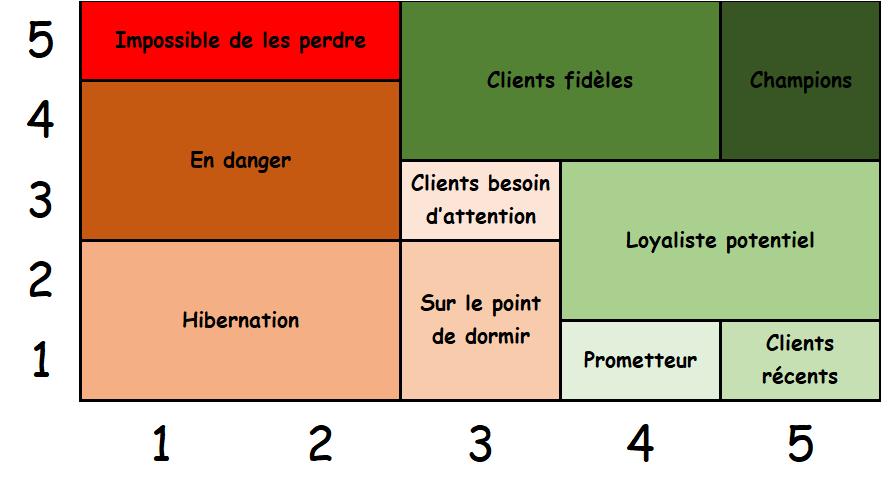

In [ ]:
segt_map = {
    r'[1-2][1-2]': 'hibernation',
    r'[1-2][3-4]': 'en danger',
    r'[1-2]5': 'impossible de les perdre',
    r'3[1-2]': 'sur le point de dormir',
    r'33': 'clients besoin d’attention',
    r'[3-4][4-5]': 'clients fidèles',
    r'41': 'prometteur',
    r'51': 'clients récents',
    r'[4-5][2-3]': 'loyaliste potentiel',
    r'5[4-5]': 'champions'
}

RFM_Segment['Segment'] = RFM_Segment['R'].map(str) + RFM_Segment['M'].map(str)
RFM_Segment['Segment'] = RFM_Segment['Segment'].replace(segt_map, regex=True)
RFM_Segment.head()

,customer_unique_id,Nouveauté,Fréquence,Monétaire,R,F,M,RFMScore,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,160,66,8573.40,4,2,3,423,loyaliste potentiel
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163,144,2721.60,4,3,1,431,prometteur
2,0000f46a3911fa3c0805444483337064,585,117,8073.00,1,3,3,133,en danger
3,0000f6ccb0745a6a4b88665a16c9f078,369,32,831.68,2,1,1,211,hibernation
4,0004aac84e0df4da2b147fca70cf8255,336,133,23940.00,2,3,4,234,en danger


### Visualiser les segments de nos clients

Maintenant que nous avons nos scores, nous pouvons faire de la visualisation de données pour avoir une meilleure idée de notre portefeuille de clients. Tout d’abord, voyons à la distribution de R, F et M.

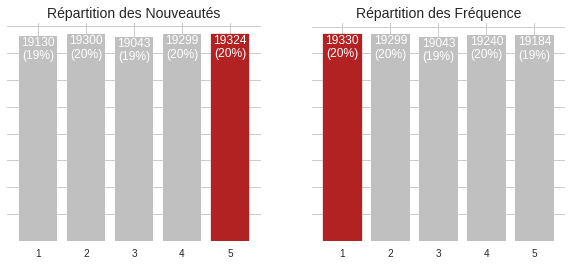

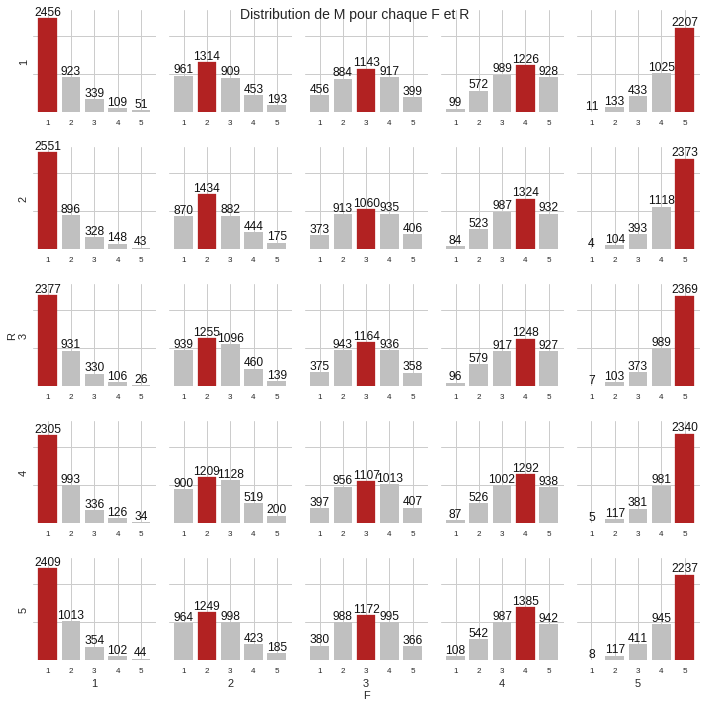

In [ ]:
# Répartition des clients sur R et F
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

for i, p in enumerate(['R', 'F']):
    parameters = {'R':'Nouveautés', 'F':'Fréquence'}
    y = RFM_Segment[p].value_counts().sort_index()
    x = y.index
    ax = axes[i]
    bars = ax.bar(x, y, color='silver')
    ax.set_frame_on(False)
    ax.tick_params(left=False, labelleft=False, bottom=False)
    ax.set_title('Répartition des {}'.format(parameters[p]),
                fontsize=14)
    for bar in bars:
        value = bar.get_height()
        if value == y.max():
            bar.set_color('firebrick')
        ax.text(bar.get_x() + bar.get_width() / 2,
                value - 5,
                '{}\n({}%)'.format(int(value), int(value * 100 / y.sum())),
               ha='center',
               va='top',
               color='w')

plt.show()

# Distribution de M pour le score RF
fig, axes = plt.subplots(nrows=5, ncols=5,
                         sharex=False, sharey=True,
                         figsize=(10, 10))

r_range = range(1, 6)
f_range = range(1, 6)
for r in r_range:
    for f in f_range:
        y = RFM_Segment[(RFM_Segment['R'] == r) & (RFM_Segment['F'] == f)]['M'].value_counts().sort_index()
        x = y.index
        ax = axes[r - 1, f - 1]
        bars = ax.bar(x, y, color='silver')
        if r == 5:
            if f == 3:
                ax.set_xlabel('{}\nF'.format(f), va='top')
            else:
                ax.set_xlabel('{}\n'.format(f), va='top')
        if f == 1:
            if r == 3:
                ax.set_ylabel('R\n{}'.format(r))
            else:
                ax.set_ylabel(r)
        ax.set_frame_on(False)
        ax.tick_params(left=False, labelleft=False, bottom=False)
        ax.set_xticks(x)
        ax.set_xticklabels(x, fontsize=8)

        for bar in bars:
            value = bar.get_height()
            if value == y.max():
                bar.set_color('firebrick')
            ax.text(bar.get_x() + bar.get_width() / 2,
                    value,
                    int(value),
                    ha='center',
                    va='bottom',
                    color='k')
fig.suptitle('Distribution de M pour chaque F et R',
             fontsize=14)
plt.tight_layout()
plt.show()

On voit que si la récence semble uniformément répartie, comme la fréquence.
Lorsque nous examinons la valeur monétaire, nous constatons que les clients qui dépensent le plus sont ceux qui ont le moins d’activité (R et F de 2-1) qui correspond au client qui hiberne. nous constatons que les clients qui dépensent le moins sont ceux qui ont une activité (R et F de [1-5][2-4]) qui correspond principalement les clients Sur le point de dormir, Prometteur, Clients besoin d'attention et Clients fidèles.

Regardons la répartition de nos segments sur ces graphiques à barres.

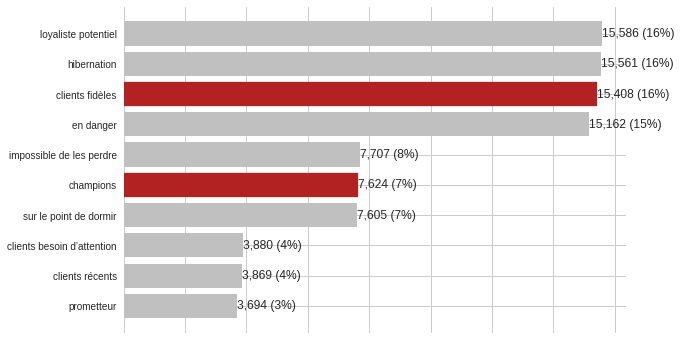

In [ ]:
# Compter le nombre de clients dans chaque segment
segments_counts = RFM_Segment['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['champions', 'clients fidèles']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

Nous avons beaucoup de clients qui n’achètent pas fréquemment chez nous (16% hibernent). Cependant, 23% de nos clients sont soit des champions, soit des clients fidèles.

Je vais effectuer une analyse plus approfondie afin d'intègrer les paramètres monétaires, avec des clients affectés à des segments et quelques statistiques sur la composition de notre portefeuille de clients, je vais travailler sur des campagnes de marketing ciblées pour fidéliser les clients à risque, améliorer les ventes aux clients ayant un certain potentiel et récompenser les meilleurs clients.

### Créer un jeu de données intégrant la ségmentation des clients

In [ ]:
data_int_seg = pd.merge(data, RFM_Segment, on='customer_unique_id',how='left')

### Analyse de la ségmentation des clients en fonction de sa position géographique

Text(0.5, 1.0, 'Répartition de la ségmentation des clients par sa position géographique')

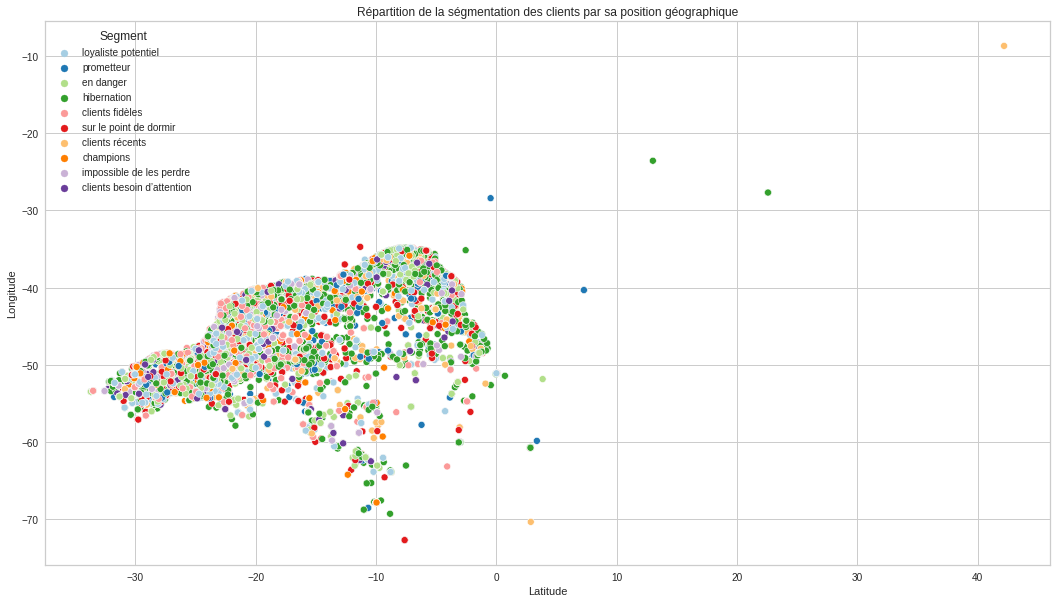

In [ ]:
plt.figure(figsize=(18,10))
g = sns.scatterplot(data= data_int_seg, x='Latitude', y='Longitude', hue='Segment', palette='Paired')
plt.title("Répartition de la ségmentation des clients par sa position géographique")

Ce graphique me permet de voir que la segmentation clients sont concentré principalement dans une zone géographique de manière uniformément réparties.

## Déterminer les carractéristiques quantitative de chaque segmentation clients

### Champions

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'champions'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,7624.000000,7624.000000,7.624000e+03,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7624.000000,7.624000e+03,7624.0,7624.000000,7624.000000
mean,320.242655,320.242655,5.082496e+04,210.876007,4.238471,99.578134,8.181182,14.760519,2.718416,3.506965,-21.866056,-46.168399,94.860310,320.242655,5.082496e+04,5.0,4.021905,4.495016
std,344.339480,344.339480,8.999921e+04,289.953832,1.239431,37.753214,4.614941,5.197389,1.961694,2.958966,4.668769,3.710592,26.173806,344.339480,8.999921e+04,0.0,1.042539,0.500008
min,9.000000,9.000000,1.245420e+04,5.105000,1.000000,34.000000,1.000000,0.000000,0.000000,1.000000,-32.079231,-72.668881,0.000000,9.000000,1.245420e+04,5.0,1.000000,4.000000
25%,138.000000,138.000000,1.801742e+04,83.861250,4.000000,72.000000,5.000000,11.000000,1.000000,1.000000,-23.599676,-47.890400,72.000000,138.000000,1.801742e+04,5.0,3.000000,4.000000
50%,231.000000,231.000000,2.741420e+04,129.900000,5.000000,93.000000,7.000000,15.000000,3.000000,2.000000,-22.926259,-46.564145,91.000000,231.000000,2.741420e+04,5.0,4.000000,4.000000
75%,380.000000,380.000000,5.016681e+04,210.900000,5.000000,121.000000,10.000000,19.000000,4.000000,5.000000,-20.605356,-43.454711,119.000000,380.000000,5.016681e+04,5.0,5.000000,5.000000
max,8022.000000,8022.000000,2.556120e+06,6729.000000,5.000000,490.743326,28.000000,23.000000,6.000000,23.000000,2.855558,-34.827391,142.000000,8022.000000,2.556120e+06,5.0,5.000000,5.000000


### Clients fidèles

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'clients fidèles'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,15408.000000,15408.000000,1.540800e+04,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,15408.000000,1.540800e+04,15408.000000,15408.000000,15408.000000
mean,329.108061,329.108061,4.883569e+04,201.315424,3.928600,229.793492,11.500755,14.804440,2.710042,3.429441,-21.915436,-46.139170,227.120132,329.108061,4.883569e+04,3.509476,4.029400,4.502207
std,361.095169,361.095169,7.944562e+04,247.751556,1.455538,52.170989,6.061300,5.183674,1.948567,2.964610,4.627467,3.669346,49.373388,361.095169,7.944562e+04,0.499926,1.059031,0.500011
min,6.000000,6.000000,1.244880e+04,7.630000,1.000000,143.000000,1.000000,0.000000,0.000000,1.000000,-33.512901,-67.848538,143.000000,6.000000,1.244880e+04,3.000000,1.000000,4.000000
25%,137.000000,137.000000,1.798495e+04,81.990000,3.000000,185.000000,7.000000,11.000000,1.000000,1.000000,-23.596804,-47.916666,184.000000,137.000000,1.798495e+04,3.000000,3.000000,4.000000
50%,236.000000,236.000000,2.774315e+04,129.990000,5.000000,228.000000,10.000000,15.000000,3.000000,2.000000,-22.920003,-46.547691,226.000000,236.000000,2.774315e+04,4.000000,4.000000,5.000000
75%,398.000000,398.000000,5.007371e+04,210.000000,5.000000,271.000000,15.000000,19.000000,4.000000,5.000000,-20.556280,-43.425522,268.000000,398.000000,5.007371e+04,4.000000,5.000000,5.000000
max,10752.000000,10752.000000,2.501664e+06,4099.990000,5.000000,617.875000,28.000000,23.000000,6.000000,24.000000,2.829995,-34.823063,317.000000,10752.000000,2.501664e+06,4.000000,5.000000,5.000000


### Loyaliste potentiel

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'loyaliste potentiel'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,15586.000000,15586.000000,15586.000000,15586.00000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000,15586.000000
mean,119.877839,119.877839,6697.627242,84.14211,4.154924,140.738719,9.035199,14.766992,2.709032,2.500758,-21.346330,-46.331919,139.268767,119.877839,6697.627242,4.502438,2.687733,2.505325
std,94.922468,94.922468,2751.895903,73.19265,1.301141,53.657608,5.613630,5.192664,1.961911,2.287711,5.499084,3.931516,52.074302,94.922468,2751.895903,0.500010,1.161051,0.499988
min,2.000000,2.000000,2729.220000,4.90000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-33.512901,-67.848538,0.000000,2.000000,2729.220000,4.000000,1.000000,2.000000
25%,58.000000,58.000000,4268.700000,39.99000,4.000000,91.000000,5.000000,11.000000,1.000000,1.000000,-23.597787,-48.013937,90.000000,58.000000,4268.700000,4.000000,2.000000,2.000000
50%,95.000000,95.000000,6299.415000,66.99000,5.000000,144.000000,8.000000,15.000000,3.000000,1.000000,-23.104373,-46.661189,142.000000,95.000000,6299.415000,5.000000,3.000000,3.000000
75%,150.750000,150.750000,8913.100000,109.00000,5.000000,184.000000,12.000000,19.000000,4.000000,3.000000,-20.670630,-44.120150,183.000000,150.750000,8913.100000,5.000000,4.000000,3.000000
max,1928.000000,1928.000000,12448.020000,2139.99000,5.000000,451.000000,28.000000,23.000000,6.000000,24.000000,2.855558,-34.823063,227.000000,1928.000000,12448.020000,5.000000,5.000000,3.000000


### clients récents

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'clients récents'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.000000,3869.0,3869.000000,3869.0
mean,47.500646,47.500646,1448.573895,50.623360,4.273667,93.931778,8.178181,14.782627,2.730538,1.993603,-20.165650,-45.996796,93.602223,47.500646,1448.573895,5.0,1.537607,1.0
std,43.185380,43.185380,740.258907,52.764461,1.180687,26.121923,5.037013,5.347359,1.956949,1.878585,6.312360,4.264475,25.645215,43.185380,740.258907,0.0,0.798424,0.0
min,1.000000,1.000000,14.900000,2.200000,1.000000,49.000000,1.000000,0.000000,0.000000,1.000000,-32.186173,-70.315200,49.000000,1.000000,14.900000,5.0,1.000000,1.0
25%,19.000000,19.000000,840.000000,21.800000,4.000000,72.000000,5.000000,11.000000,1.000000,1.000000,-23.575769,-47.889147,72.000000,19.000000,840.000000,5.0,1.000000,1.0
50%,36.000000,36.000000,1467.800000,34.900000,5.000000,90.000000,7.000000,15.000000,3.000000,1.000000,-22.980563,-46.639347,90.000000,36.000000,1467.800000,5.0,1.000000,1.0
75%,65.000000,65.000000,2071.000000,59.900000,5.000000,117.000000,11.000000,19.000000,4.000000,2.000000,-16.697834,-44.156008,116.000000,65.000000,2071.000000,5.0,2.000000,1.0
max,694.000000,694.000000,2728.000000,879.330000,5.000000,258.500000,28.000000,23.000000,6.000000,18.000000,42.184003,-8.723762,142.000000,694.000000,2728.000000,5.0,5.000000,1.0


### Prometteur

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'prometteur'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.000000,3694.0,3694.000000,3694.0
mean,47.337574,47.337574,1465.182999,50.389953,4.024607,186.519624,10.428774,14.652459,2.703842,2.020113,-20.194885,-45.981241,185.832972,47.337574,1465.182999,4.0,1.534651,1.0
std,40.134077,40.134077,744.859259,58.348423,1.368372,25.884603,6.418079,5.188124,1.981658,1.836255,6.378917,4.349263,23.915864,40.134077,744.859259,0.0,0.788330,0.0
min,1.000000,1.000000,13.500000,0.850000,1.000000,143.000000,1.000000,0.000000,0.000000,0.000000,-32.235661,-68.502935,143.000000,1.000000,13.500000,4.0,1.000000,1.0
25%,20.000000,20.000000,857.550000,20.300000,4.000000,165.000000,6.000000,11.000000,1.000000,1.000000,-23.571690,-47.946861,164.000000,20.000000,857.550000,4.0,1.000000,1.0
50%,36.000000,36.000000,1481.480000,35.000000,5.000000,185.000000,9.000000,15.000000,3.000000,1.000000,-22.911072,-46.638848,185.000000,36.000000,1481.480000,4.0,1.000000,1.0
75%,65.000000,65.000000,2104.700000,59.900000,5.000000,208.000000,14.000000,19.000000,4.000000,2.000000,-17.305094,-43.824785,207.000000,65.000000,2104.700000,4.0,2.000000,1.0
max,518.000000,518.000000,2729.090000,1799.000000,5.000000,445.000000,28.000000,23.000000,6.000000,15.000000,7.271649,-28.424444,227.000000,518.000000,2729.090000,4.0,5.000000,1.0


### Clients besoin d’attention

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'clients besoin d’attention'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.000000,3880.0,3880.000000,3880.0
mean,142.628351,142.628351,8978.811443,96.837146,3.923534,271.358518,12.014439,14.756746,2.777873,2.673199,-21.396621,-46.398970,270.425258,142.628351,8978.811443,3.0,2.976031,3.0
std,112.068075,112.068075,1775.845336,74.142456,1.440868,28.211126,6.340838,5.357218,1.948488,2.418537,5.574032,4.050211,26.477833,112.068075,1775.845336,0.0,1.115035,0.0
min,9.000000,9.000000,6253.000000,5.990000,1.000000,228.000000,1.000000,0.000000,0.000000,1.000000,-33.689948,-72.668881,228.000000,9.000000,6253.000000,3.0,1.000000,3.0
25%,73.000000,73.000000,7405.432500,49.900000,3.000000,247.000000,8.000000,11.000000,1.000000,1.000000,-23.598879,-48.426466,247.000000,73.000000,7405.432500,3.0,2.000000,3.0
50%,110.000000,110.000000,8834.000000,79.900000,5.000000,271.000000,10.000000,15.000000,3.000000,2.000000,-22.960625,-46.655399,270.000000,110.000000,8834.000000,3.0,3.000000,3.0
75%,176.000000,176.000000,10479.350000,120.000000,5.000000,293.000000,16.000000,19.000000,4.000000,3.000000,-20.472110,-43.989077,292.000000,176.000000,10479.350000,3.0,4.000000,3.0
max,1460.000000,1460.000000,12448.340000,899.000000,5.000000,456.000000,28.000000,23.000000,6.000000,14.000000,0.033395,-34.823063,317.000000,1460.000000,12448.340000,3.0,5.000000,3.0


### Sur le point de dormir

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'sur le point de dormir'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.000000,7605.0,7605.000000,7605.000000
mean,71.648126,71.648126,2875.575115,58.854974,4.012349,270.201017,11.985888,14.743351,2.695398,2.134697,-20.266513,-46.173280,269.869691,71.648126,2875.575115,3.0,1.959237,1.501118
std,63.087604,63.087604,1716.828664,52.757721,1.374348,26.946067,6.433486,5.422448,1.927218,1.984717,6.393304,4.417391,26.284072,63.087604,1716.828664,0.0,1.044975,0.500032
min,1.000000,1.000000,5.600000,2.990000,1.000000,228.000000,1.000000,0.000000,0.000000,1.000000,-32.195805,-72.668881,228.000000,1.000000,5.600000,3.0,1.000000,1.000000
25%,29.000000,29.000000,1399.860000,25.990000,3.000000,247.000000,8.000000,11.000000,1.000000,1.000000,-23.582265,-48.469773,247.000000,29.000000,1399.860000,3.0,1.000000,1.000000
50%,54.000000,54.000000,2737.500000,45.000000,5.000000,268.000000,10.000000,15.000000,3.000000,1.000000,-22.900743,-46.657580,268.000000,54.000000,2737.500000,3.0,2.000000,2.000000
75%,95.000000,95.000000,4273.500000,74.990000,5.000000,291.000000,16.000000,19.000000,4.000000,3.000000,-18.383282,-43.930740,290.000000,95.000000,4273.500000,3.0,3.000000,2.000000
max,733.000000,733.000000,6249.300000,934.940000,5.000000,451.000000,28.000000,23.000000,6.000000,15.000000,2.855558,-34.725130,317.000000,733.000000,6249.300000,3.0,5.000000,2.000000


### En danger

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'en danger'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000,15162.000000
mean,188.051247,188.051247,13924.742076,114.274749,4.076970,445.325059,10.653518,14.843968,2.812632,3.158507,-21.544415,-46.299509,444.759662,188.051247,13924.742076,1.502506,3.390977,3.507783
std,149.177512,149.177512,5861.464095,111.456163,1.347465,93.439845,5.437699,5.334253,1.958746,2.816595,5.423049,3.936281,93.573312,149.177512,5861.464095,0.500010,1.161922,0.499956
min,2.000000,2.000000,6249.900000,4.500000,1.000000,318.000000,1.000000,0.000000,0.000000,1.000000,-33.689948,-67.876759,318.000000,2.000000,6249.900000,1.000000,1.000000,3.000000
25%,92.000000,92.000000,8905.150000,55.967500,4.000000,364.007541,7.000000,11.000000,1.000000,1.000000,-23.601255,-48.401486,364.000000,92.000000,8905.150000,1.000000,3.000000,3.000000
50%,145.000000,145.000000,12587.950000,89.500000,5.000000,434.000000,9.000000,15.000000,3.000000,2.000000,-22.929869,-46.636790,433.000000,145.000000,12587.950000,2.000000,3.000000,4.000000
75%,238.000000,238.000000,18169.910000,139.420000,5.000000,515.000000,13.717008,19.000000,4.000000,4.000000,-20.469269,-43.626147,515.000000,238.000000,18169.910000,2.000000,4.000000,4.000000
max,2000.000000,2000.000000,27636.000000,3699.990000,5.000000,764.000000,28.000000,23.000000,6.000000,24.000000,3.842508,-34.823063,764.000000,2000.000000,27636.000000,2.000000,5.000000,4.000000


### Impossible de les perdre

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'impossible de les perdre'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,7707.000000,7707.000000,7.707000e+03,7707.000000,7707.000000,7707.000000,7707.000000,7707.00000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7707.000000,7.707000e+03,7707.000000,7707.000000,7707.0
mean,440.583236,440.583236,8.229764e+04,286.921519,4.051748,445.449237,10.890609,14.82818,2.819899,4.276980,-21.832672,-45.907331,444.318801,440.583236,8.229764e+04,1.509796,4.357727,5.0
std,478.427240,478.427240,1.452996e+05,361.052267,1.378749,95.100205,5.363184,5.25875,1.954263,3.493185,4.541104,3.793556,95.327619,478.427240,1.452996e+05,0.499936,0.933609,0.0
min,15.000000,15.000000,2.764540e+04,9.730000,1.000000,318.000000,1.000000,0.00000,0.000000,1.000000,-33.512901,-67.834306,318.000000,15.000000,2.764540e+04,1.000000,1.000000,5.0
25%,188.000000,188.000000,3.589467e+04,101.420000,4.000000,362.000000,7.000000,11.00000,1.000000,1.000000,-23.557414,-47.815291,361.000000,188.000000,3.589467e+04,1.000000,4.000000,5.0
50%,328.000000,328.000000,5.045625e+04,175.500000,5.000000,433.000000,10.000000,15.00000,3.000000,3.000000,-22.896408,-46.343581,431.000000,328.000000,5.045625e+04,2.000000,5.000000,5.0
75%,534.000000,534.000000,8.393475e+04,309.995000,5.000000,517.000000,14.000000,19.00000,4.000000,7.000000,-20.338853,-43.290769,516.000000,534.000000,8.393475e+04,2.000000,5.000000,5.0
max,11427.000000,11427.000000,6.662844e+06,6735.000000,5.000000,762.000000,28.000000,23.00000,6.000000,24.000000,0.017415,-34.834452,762.000000,11427.000000,6.662844e+06,2.000000,5.000000,5.0


### Hibernation

In [ ]:
data_int_seg[data_int_seg['Segment'] == 'hibernation'].describe()

,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M
count,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000,15561.000000
mean,71.038686,71.038686,2884.189679,60.970543,4.065908,446.121797,10.959978,14.757690,2.817348,2.424667,-20.177743,-46.096389,445.915430,71.038686,2884.189679,1.498168,1.942934,1.494570
std,65.334316,65.334316,1703.933207,59.228950,1.331442,93.979639,5.724935,5.452374,1.965174,2.173599,6.580166,4.574642,94.020153,65.334316,1703.933207,0.500013,1.038504,0.499987
min,1.000000,1.000000,10.990000,1.514286,1.000000,318.000000,1.000000,0.000000,0.000000,1.000000,-33.689948,-69.261385,318.000000,1.000000,10.990000,1.000000,1.000000,1.000000
25%,29.000000,29.000000,1452.000000,26.833333,4.000000,363.000000,7.000000,11.000000,1.000000,1.000000,-23.578873,-48.453638,363.000000,29.000000,1452.000000,1.000000,1.000000,1.000000
50%,54.000000,54.000000,2699.700000,46.900000,5.000000,434.000000,10.000000,15.000000,3.000000,1.000000,-22.893703,-46.644090,434.000000,54.000000,2699.700000,1.000000,2.000000,1.000000
75%,93.000000,93.000000,4271.100000,75.000000,5.000000,518.000000,14.000000,19.000000,4.000000,3.000000,-17.873743,-43.583791,518.000000,93.000000,4271.100000,2.000000,3.000000,2.000000
max,1890.000000,1890.000000,6249.100000,1340.000000,5.000000,772.000000,28.000000,23.000000,6.000000,24.000000,22.567952,-23.583939,772.000000,1890.000000,6249.100000,2.000000,5.000000,2.000000


## Déterminer les carractéristiques qualitative de chaque sègmentation clients

### Analyse statistique données catégoriques en fonction de la segmentation clients

In [ ]:
data_int_seg.groupby('Segment')['Villes'].describe()

,count,unique,top,freq
Segment,,,,
champions,7624,1006,rio de janeiro,829
clients besoin d’attention,3880,937,sao paulo,611
clients fidèles,15408,1278,rio de janeiro,1738
clients récents,3869,1019,sao paulo,1015
en danger,15162,1633,sao paulo,1944
hibernation,15561,2683,sao paulo,2944
impossible de les perdre,7707,901,rio de janeiro,1150
loyaliste potentiel,15586,1834,sao paulo,3223
prometteur,3694,1005,sao paulo,821


In [ ]:
data_int_seg.groupby('Segment')['Cat_prod'].describe()

,count,unique,top,freq
Segment,,,,
champions,7419,12,home,1440
clients besoin d’attention,3820,12,home,808
clients fidèles,15090,12,home,2945
clients récents,3778,12,electronics,789
en danger,14975,12,home,3491
hibernation,15418,12,home,3138
impossible de les perdre,7584,12,home,1631
loyaliste potentiel,15262,12,home,2844
prometteur,3613,12,electronics,951


In [ ]:
data_int_seg.groupby('Segment')['Type_paiement'].describe()

,count,unique,top,freq
Segment,,,,
champions,7624,4,credit_card,6079
clients besoin d’attention,3880,4,credit_card,3029
clients fidèles,15408,4,credit_card,12428
clients récents,3869,4,credit_card,2801
en danger,15162,4,credit_card,11679
hibernation,15561,4,credit_card,11426
impossible de les perdre,7707,4,credit_card,6232
loyaliste potentiel,15586,4,credit_card,12029
prometteur,3694,4,credit_card,2792


## Conclusion sur la segmentation client

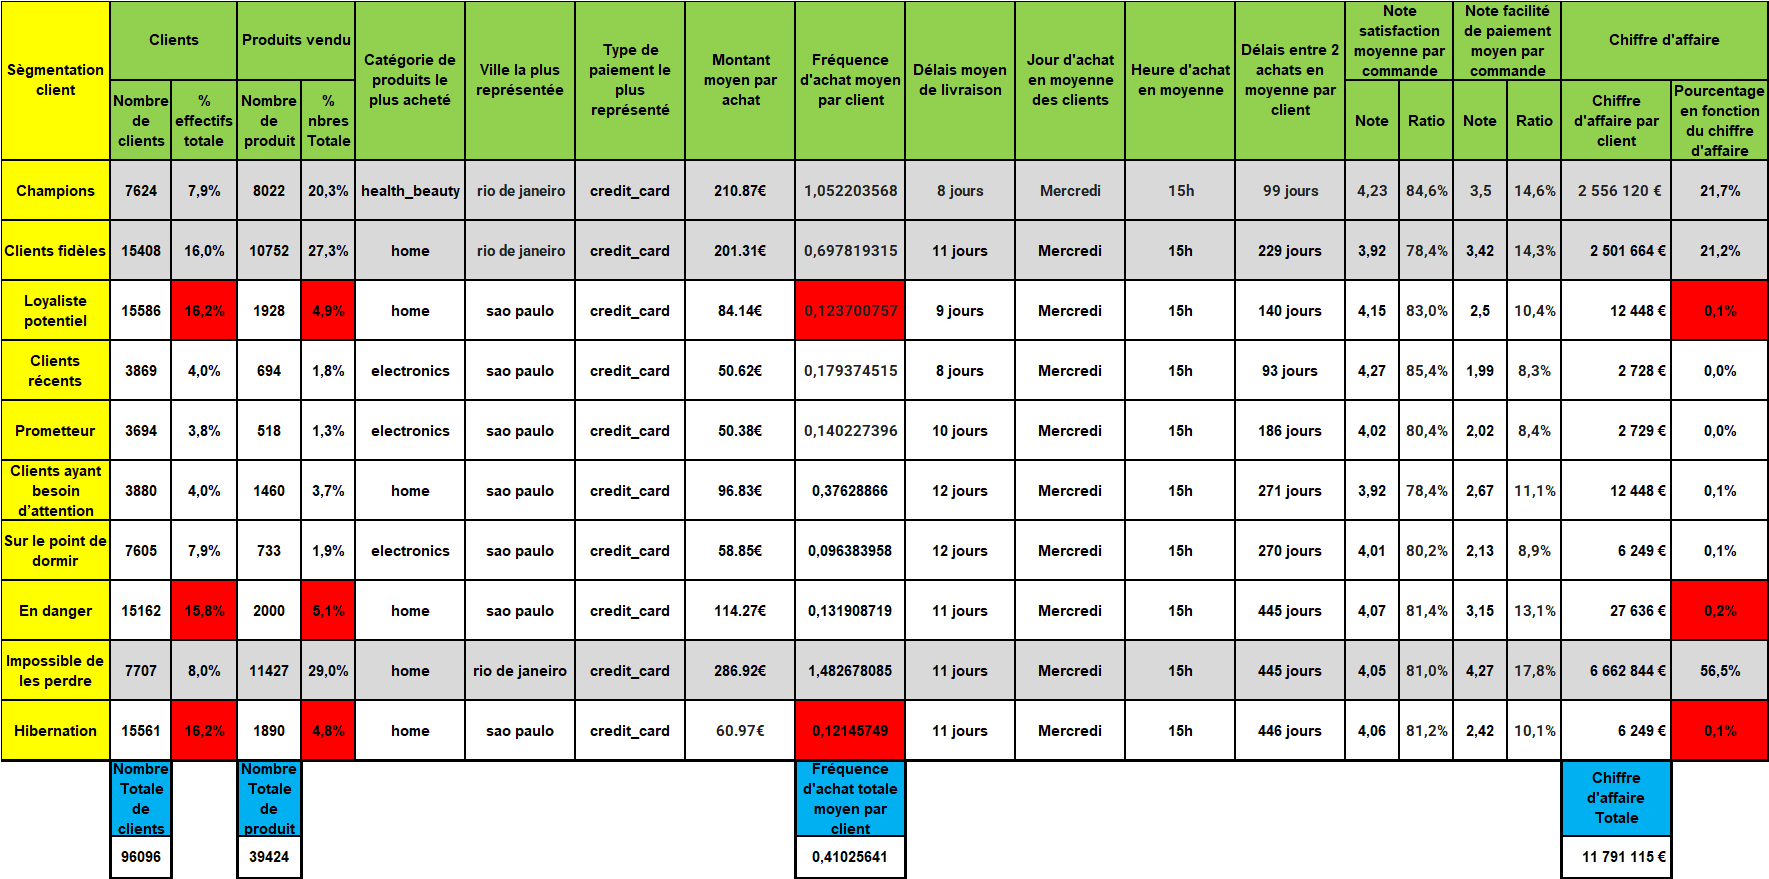

Pour conclure sur la ségmentation client, ce tableau décrit les différents types de comportements des clients en fonction de ces différentes caractéristiques quantitatives et qualitative, ce qui en ressort tout d'abord c'est que 3 types de comportements champions, clients fidèles et impossible de les perdre représentent à eux 3 près de 100% du chiffre d'affaire pour seulement 29,9% de l'effectifs totale de clients, néanmoins les comportements restant représentent seulement 0,6% du chiffre d'affaire pour 70,1% de l'effectifs totale de clients.

### Préparation du jeu de données

In [ ]:
data_int_seg.head()

,customer_unique_id,Nb_pdts,Nb_com,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Date_dernier_achat,Villes,Cat_prod,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Type_paiement,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M,RFMScore,Segment
0,0000366f3b9a7992bf8c76cfdf3221e2,66,66,8573.40,129.90,5.0,2018-05-10 10:56:27,cajamar,home,160.0,6.0,10.0,3.0,credit_card,8.0,-23.340235,-46.830140,160,66,8573.40,4,2,3,423,loyaliste potentiel
1,0000b849f77a49e4a4ce2b2a4ca5be3f,144,144,2721.60,18.90,4.0,2018-05-07 11:11:27,osasco,health_beauty,163.0,3.0,11.0,0.0,credit_card,1.0,-23.559115,-46.787626,163,144,2721.60,4,3,1,431,prometteur
2,0000f46a3911fa3c0805444483337064,117,117,8073.00,69.00,3.0,2017-03-10 21:05:03,sao jose,office,585.0,25.0,21.0,4.0,credit_card,8.0,-27.542880,-48.633426,585,117,8073.00,1,3,3,133,en danger
3,0000f6ccb0745a6a4b88665a16c9f078,32,32,831.68,25.99,4.0,2017-10-12 20:29:41,belem,electronics,369.0,20.0,20.0,3.0,credit_card,4.0,-1.312214,-48.483159,369,32,831.68,2,1,1,211,hibernation
4,0004aac84e0df4da2b147fca70cf8255,133,133,23940.00,180.00,5.0,2017-11-14 19:45:42,sorocaba,electronics,336.0,13.0,19.0,1.0,credit_card,6.0,-23.505548,-47.469705,336,133,23940.00,2,3,4,234,en danger


In [ ]:
data_int_seg.shape

(96096, 25)

In [ ]:
data_int_seg = data_int_seg.drop(columns=['Nb_com'])

J'ai supprimer la variable nombre de commande car elle très fortement corrélé au nombre de produit.

In [ ]:
data_int_seg.shape

(96096, 24)

In [ ]:
data_int_seg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96096 entries, 0 to 96095
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   customer_unique_id       96096 non-null  object        
 1   Nb_pdts                  96096 non-null  int64         
 2   Mont_max_achats          96096 non-null  float64       
 3   Mont_moy_achats          96096 non-null  float64       
 4   Note_Moy_Com             96096 non-null  float64       
 5   Date_dernier_achat       96096 non-null  datetime64[ns]
 6   Villes                   96096 non-null  object        
 7   Cat_prod                 94415 non-null  object        
 8   Delai_moy_dernier_achat  96096 non-null  float64       
 9   Delai_Moy_Livraison      96096 non-null  float64       
 10  Heure_achat_moy          96096 non-null  float64       
 11  Jour_achat_moy           96096 non-null  float64       
 12  Type_paiement            96096 n

In [ ]:
df_r = data_int_seg.copy()

## Préparer le jeu de données

### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = df_r[val_num]

### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = df_r[val_cat]

### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)
scaled_features.head()

,Nb_pdts,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude
0,-0.463807,-0.226709,0.019835,0.687357,-0.842857,-0.764104,-0.903437,0.125146,1.902698,-0.383952,-0.161904
1,-0.170377,-0.319193,-0.561692,-0.051276,-0.823270,-1.279061,-0.714511,-1.407767,-0.710130,-0.422938,-0.151415
2,-0.271949,-0.234617,-0.299219,-0.789909,1.931978,2.497287,1.174744,0.636116,1.902698,-1.132513,-0.606812
3,-0.591712,-0.349062,-0.524548,-0.051276,0.521709,1.639026,0.985819,0.125146,0.409653,3.539607,-0.569738
4,-0.211758,0.016150,0.282308,0.687357,0.306251,0.437461,0.796893,-0.896796,1.156175,-0.413397,-0.319698


### Encodage à chaud

In [ ]:
df = scaled_features.join(df_cat)

In [ ]:
df = pd.get_dummies(df, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

## Choisir la segmentation le plus performant entre le KMeans et le CAH

### KMEANS

#### Technique du coude

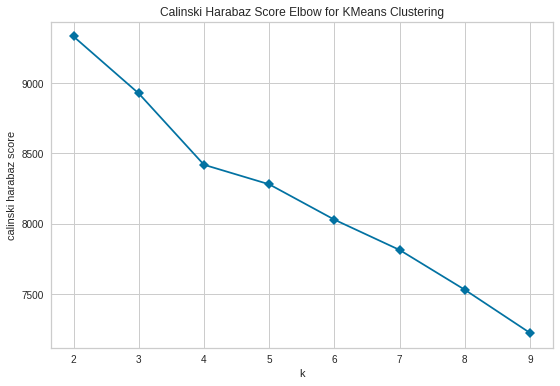

In [ ]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10), metric='calinski_harabaz', timings=False)

visualizer.fit(df)   
visualizer.poof() 

Ici, nous voyons que la partie la plus marquée du coude est k=4. Qui me permet de partir sur une base de 4 clusters optimale.

#### Effectuer une analyse comparative pour déterminer la meilleure valeur de K à l’aide du tracé de silhouette

Pour k= 2

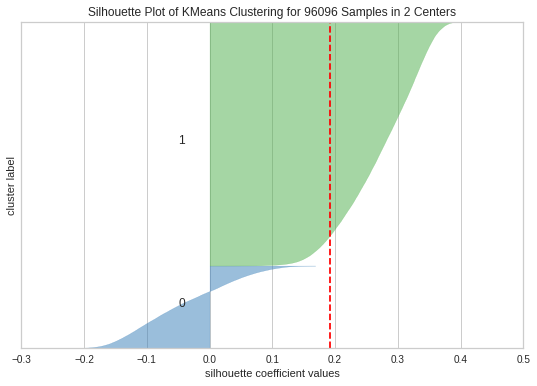

In [ ]:
model2 = KMeans(2)
visualizer = SilhouetteVisualizer(model2)

visualizer.fit(df)    
visualizer.poof() 

In [ ]:
model2.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model2.labels_, metric='sqeuclidean')

0.3395096597043642

Pour k= 3

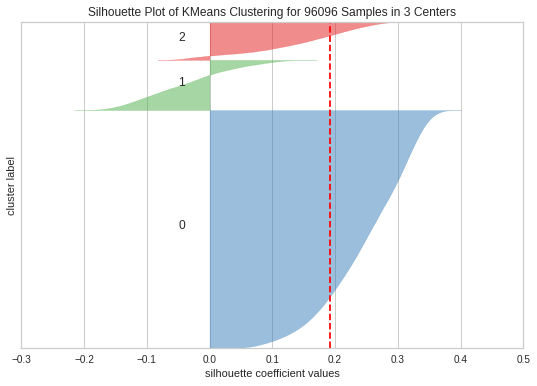

In [ ]:
model3 = KMeans(3)
visualizer = SilhouetteVisualizer(model3)

visualizer.fit(df)    
visualizer.poof()  

In [ ]:
model3.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model3.labels_, metric='sqeuclidean')

0.31428333661102864

Pour k= 4

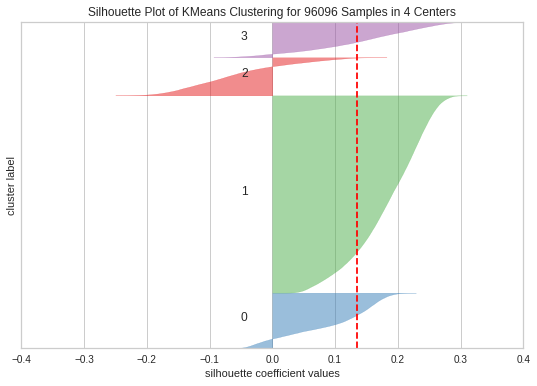

In [ ]:
model4 = KMeans(4)
visualizer = SilhouetteVisualizer(model4)

visualizer.fit(df)    
visualizer.poof() 

In [ ]:
model4.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model4.labels_, metric='sqeuclidean')

0.24186018066892057

Pour k= 5

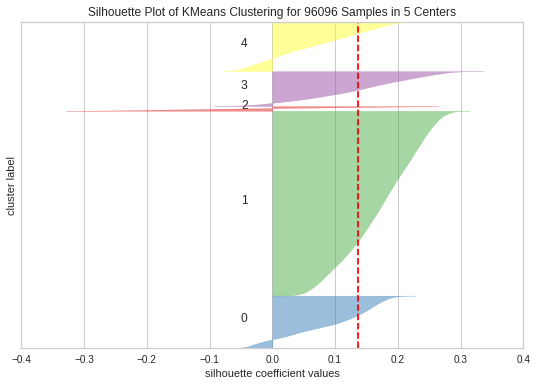

In [ ]:
model5 = KMeans(5)
visualizer = SilhouetteVisualizer(model5)

visualizer.fit(df)    
visualizer.poof() 

In [ ]:
model5.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model5.labels_, metric='sqeuclidean')

0.23696735638706873

#### Pour K=6

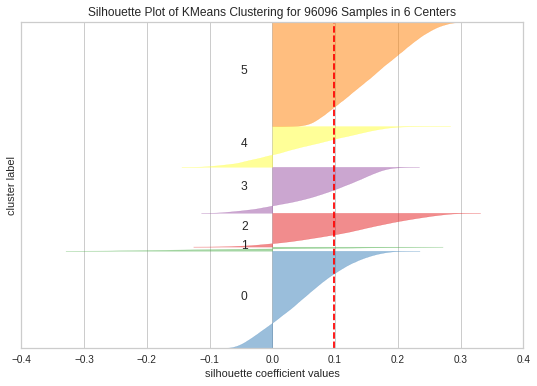

In [ ]:
model6 = KMeans(6)
visualizer = SilhouetteVisualizer(model6)

visualizer.fit(df)    
visualizer.poof()  

In [ ]:
model6.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model6.labels_, metric='sqeuclidean')

0.16436842729725382

##### Pour K=7

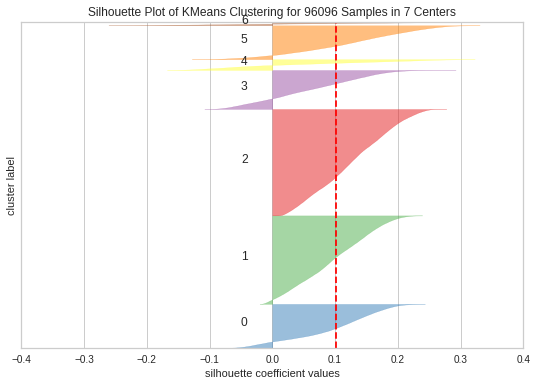

In [ ]:
model7 = KMeans(7)
visualizer = SilhouetteVisualizer(model7)

visualizer.fit(df)    
visualizer.poof()  

In [ ]:
model7.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model7.labels_, metric='sqeuclidean')

0.16920614015202473

##### Pour K=8

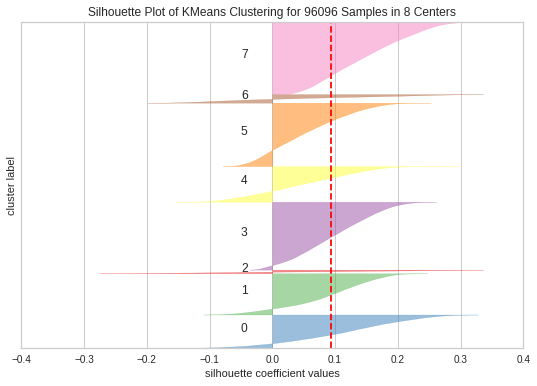

In [ ]:
model8 = KMeans(8)
visualizer = SilhouetteVisualizer(model8)

visualizer.fit(df)    
visualizer.poof()  

In [ ]:
model8.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model8.labels_, metric='sqeuclidean')

0.1534267708578577

Pour K=9

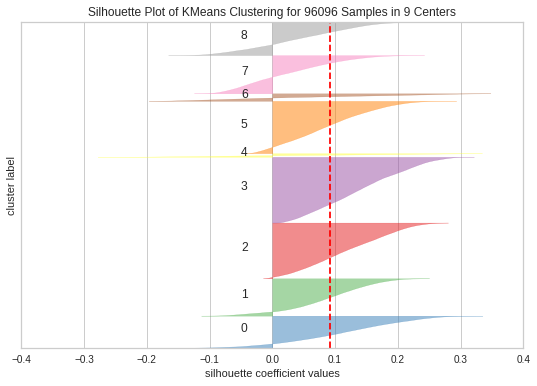

In [ ]:
model9 = KMeans(9)
visualizer = SilhouetteVisualizer(model9)

visualizer.fit(df)    
visualizer.poof()  

In [ ]:
model9.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=9, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
silhouette_score(df, model9.labels_, metric='sqeuclidean')

0.1526817673816405

### CAH(Classification ascendante hiérarchique)


In [ ]:
d_r = df.sample(n=10000)

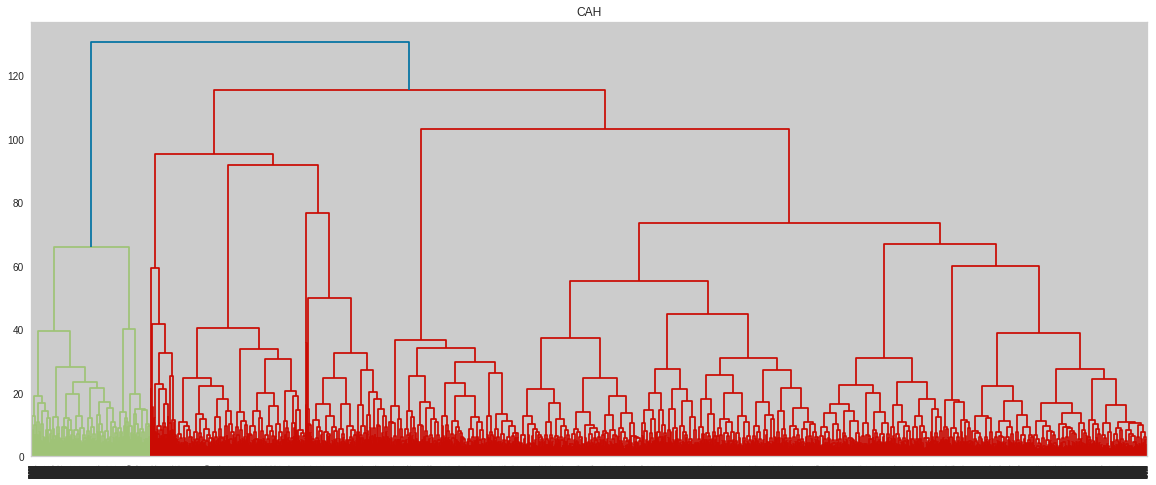

2 groupes constitués


In [ ]:
#calcul et affichage du dendrogramme

Z = linkage(d_r,method='ward',metric='euclidean') 

#affichage du dendrogramme
plt.figure(figsize=(20,8))
plt.title("CAH") 
R=dendrogram(Z,labels=d_r.index,color_threshold=130)
plt.show() 

groupes_cah = sch.fcluster(Z,t=130,criterion='distance') 
idg = np.argsort(groupes_cah) 
print(np.unique(groupes_cah).size, "groupes constitués")

#### Evaluation des performance de la ségmentation CAH

In [ ]:
silhouette_score(d_r, groupes_cah, metric='sqeuclidean')

0.31673381319636074

## Conclusion sur le choix de la ségmentation

Le choix se portera sur le KMeans qui a la meilleur performance pour le modéle2 qui est constitué de 7 clusters.

## Application de la ségmentation la plus performante

In [ ]:
df_r['Clusters'] = model2.labels_

## Déterminer les carractéristiques quantitative de chaque clusters

### Clusters 0

In [ ]:
df_r[df_r['Clusters'] == 0].describe()

,Nb_pdts,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M,Clusters
count,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.000000,71796.0
mean,178.471210,15247.197156,92.258468,4.208666,281.501897,9.015549,14.789611,2.715714,2.295351,-23.068001,-47.313045,280.239707,178.471210,15247.197156,3.073207,3.035225,2.884952,0.0
std,200.080033,21225.203355,85.743093,1.249480,153.298446,4.915517,5.272961,1.961232,2.031520,3.173049,3.131147,153.539648,200.080033,21225.203355,1.425208,1.375398,1.357138,0.0
min,1.000000,5.600000,0.850000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-33.689948,-72.668881,0.000000,1.000000,5.600000,1.000000,1.000000,1.000000,0.0
25%,62.000000,3329.167500,38.990000,4.000000,158.000000,6.000000,11.000000,1.000000,1.000000,-23.651294,-48.833371,156.000000,62.000000,3329.167500,2.000000,2.000000,2.000000,0.0
50%,118.000000,7999.775000,69.900000,5.000000,261.000000,8.000000,15.000000,3.000000,1.000000,-23.432328,-46.726115,260.000000,118.000000,7999.775000,3.000000,3.000000,3.000000,0.0
75%,222.000000,18356.490000,119.000000,5.000000,391.000000,12.000000,19.000000,4.000000,3.000000,-22.359934,-46.319208,389.000000,222.000000,18356.490000,4.000000,4.000000,4.000000,0.0
max,5112.000000,382063.500000,1449.000000,5.000000,772.000000,28.000000,23.000000,6.000000,18.000000,2.855558,-38.445060,772.000000,5112.000000,382063.500000,5.000000,5.000000,5.000000,0.0


### Clusters 1

In [ ]:
df_r[df_r['Clusters'] == 1].describe()

,Nb_pdts,Mont_max_achats,Mont_moy_achats,Note_Moy_Com,Delai_moy_dernier_achat,Delai_Moy_Livraison,Heure_achat_moy,Jour_achat_moy,Note_facil_pai_moy,Latitude,Longitude,Nouveauté,Fréquence,Monétaire,R,F,M,Clusters
count,24300.000000,2.430000e+04,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,24300.000000,2.430000e+04,24300.000000,24300.000000,24300.000000,24300.0
mean,221.254815,4.558232e+04,226.142373,3.658011,311.525009,14.693993,14.759400,2.871401,4.696374,-15.620032,-42.808276,309.883086,221.254815,4.558232e+04,2.799630,2.881481,3.339753,1.0
std,399.747530,1.175346e+05,330.108388,1.552205,150.545000,6.223929,5.352276,1.940097,3.447290,7.311613,4.565021,150.887834,399.747530,1.175346e+05,1.364229,1.522817,1.520955,0.0
min,1.000000,1.199000e+01,3.900000,1.000000,49.000000,1.000000,0.000000,0.000000,0.000000,-32.040291,-67.876759,0.000000,1.000000,1.199000e+01,1.000000,1.000000,1.000000,1.0
25%,44.000000,4.060000e+03,64.990000,3.000000,197.000000,9.000000,11.000000,1.000000,1.000000,-22.551245,-46.402502,195.000000,44.000000,4.060000e+03,2.000000,1.000000,2.000000,1.0
50%,100.000000,1.332875e+04,120.871429,4.000000,301.000000,14.000000,15.000000,3.000000,4.000000,-17.877228,-43.193798,298.000000,100.000000,1.332875e+04,3.000000,3.000000,4.000000,1.0
75%,248.000000,4.375640e+04,230.000000,5.000000,421.000000,19.000000,19.000000,4.000000,8.000000,-8.772074,-39.065349,418.000000,248.000000,4.375640e+04,4.000000,4.000000,5.000000,1.0
max,11427.000000,6.662844e+06,6735.000000,5.000000,772.000000,28.000000,23.000000,6.000000,24.000000,42.184003,-8.723762,772.000000,11427.000000,6.662844e+06,5.000000,5.000000,5.000000,1.0


## Déterminer les carractéristiques qualitative de chaque clusters

### Analyse statistique données catégoriques en fonction de clusters

In [ ]:
df_r.groupby('Clusters')['Villes'].describe()

,count,unique,top,freq
Clusters,,,,
0,71796,2905,sao paulo,14059
1,24300,2603,rio de janeiro,1983


In [ ]:
df_r.groupby('Clusters')['Cat_prod'].describe()

,count,unique,top,freq
Clusters,,,,
0,70460,12,home,14083
1,23955,12,home,4439


In [ ]:
df_r.groupby('Clusters')['Type_paiement'].describe()

,count,unique,top,freq
Clusters,,,,
0,71796,4,credit_card,53300
1,24300,4,credit_card,20796


In [ ]:
df_r.groupby('Clusters')['Segment'].describe()

,count,unique,top,freq
Clusters,,,,
0,71796,10,loyaliste potentiel,13138
1,24300,10,clients fidèles,5071


## CONCLUSION SUR LES CARACTERISTIQUES QUANTITATIVE ET QUALITATIVE POUR CHAQUE CLUSTERS.

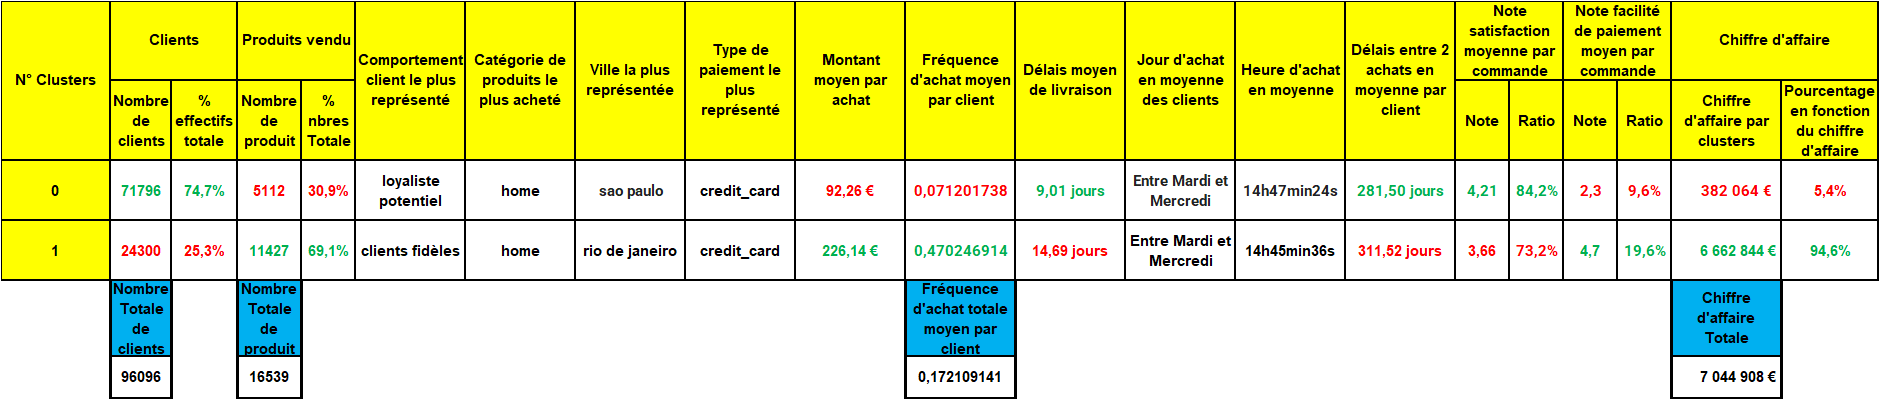

Pour conclure sur la méthode KMeans, ce tableau partitionne 2 groupes homogène admettant des caractéristiques quantitatives et qualitatives communes:
- Tout d'abord le premiers cluster avec l'étiquette '0' regroupe un nombre de 71 796 clients représentant 74,7% de la clientèle, le nombre de produit vendu est de 5112 représentant 30,9% des produits vendus, le comportement client le plus représentatif est loyaliste potentiel, la famille de produits la plus acheté est 'home', la ville la plus représenté est Sao Paulo, le type de paiement le plus utilisé est 'credit_card', le montant moyen par achat est de 92,26€, avec une fréquence d'achat moyen d'environ 0,071, un délai moyen de livraison de 9,01 jours, des achat qui s'effectue en moyenne du Mardi au Mercredi, l'heure d'achat moyen est à 14h47min24s, le délais moyen entre 2 achats est de 281,5 jours, la note moyenne de satisfaction clients est de 4,21 représentant 84,2% de la note de satifaction total, la note de facilité de paiement est de 2,3 représentant 9,6% de la note total de facilité de paiement et pour finir le chiffre d'affaire du clusters est de 382 064 € représentant 5,4% du chiffre d'affaire total.
- En second lieu,  le  cluster avec l'étiquette '1' regroupe un nombre de 24 300 clients représentant 25,3% de la clientèle, le nombre de produit vendu est de 11 427 représentant 69,1% des produits vendus, le comportement client le plus représentatif est client fidèles, la famille de produits la plus acheté est 'home', la ville la plus représenté est Rio de Janeiro, le type de paiement le plus utilisé est 'credit_card', le montant moyen par achat est de 226,14€, avec une fréquence d'achat moyen d'environ 0,47, un délai moyen de livraison de 14,69 jours, des achat qui s'effectue en moyenne du Mardi au Mercredi, l'heure d'achat moyen est à 14h45min36s, le délais moyen entre 2 achats est de 311,52 jours, la note moyenne de satisfaction clients est de 3,66 représentant 73,2% de la note de satifaction total, la note de facilité de paiement est de 4,7 représentant 19,6% de la note total de facilité de paiement et pour finir le chiffre d'affaire du clusters est de 6 662 844 € représentant 94,6% du chiffre d'affaire total.

Avantage:
- Le clusters '0' a le plus grand nombre de client, un délai moyen de livraison et un délai moyen entre 2 achats les plus faible et la meilleurs note de satisfaction clients.
- Le clusters '1' a le plus grand nombre de produit vendu, le montant moyen par achat le plus élevé, la fréquence d'achat la plus élevé, la meilleurs note de facilité de paiement et le chiffre d'affaire le plus élevé.

Inconvénient:
- Le clusters '0' a le nombre de produit vendu le plus faible, le montant moyen par achat le plus faible, la fréquence moyenne d'achat la plus faible,, la note de facilité de paiement la plus faible et le chiffre d'affaire le plus faible.
- Le clusters '1' a le nombre de client le plus faible,le délais moyen de livraison le plus élevé, le délais moyen entre 2 achats le plus élevé et la note de satisfaction clients la plus faible.

Ce qui ressort de cette analyse c'est que seulement 1/4 des clients réalisent à eux seules pas loin de 100% du chiffre d'affaire.


## T-SNE

Utilisons l'algorithme T-SNE pour avoir une idée en première approche du nombre de groupes homogènes

In [ ]:
tsne = TSNE(n_components=2)
T = tsne.fit_transform(df)

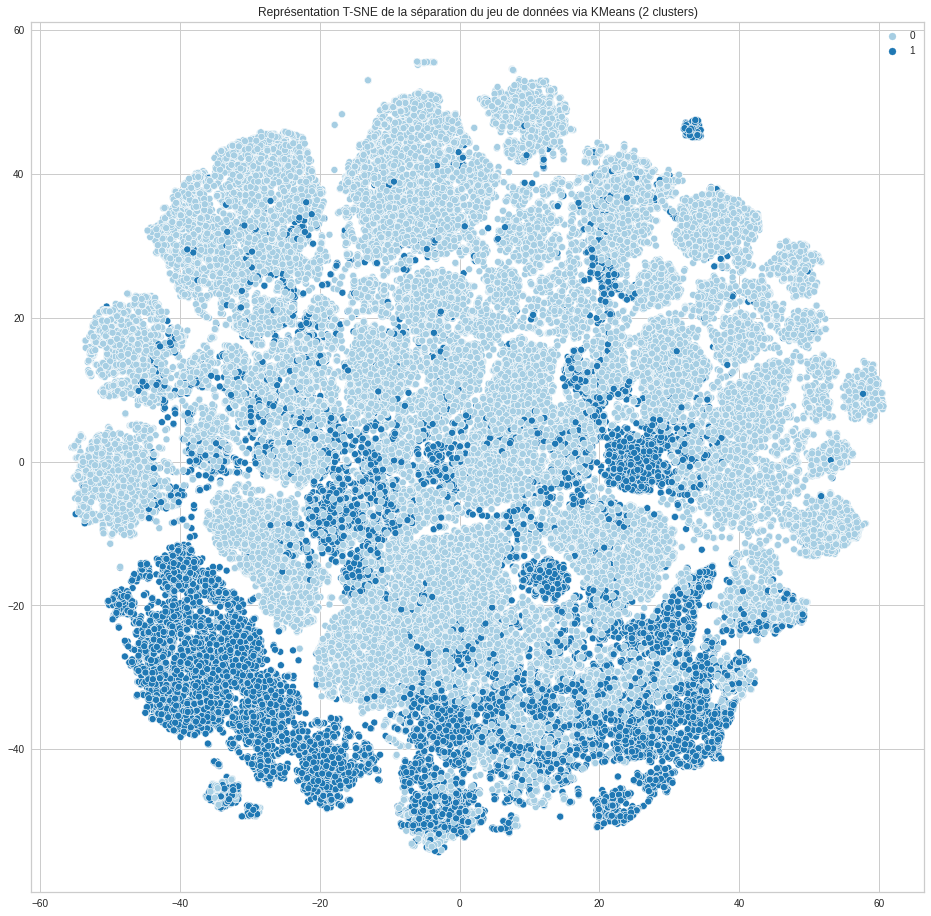

In [ ]:
plt.figure(figsize=(16,16))
plt.title('Représentation T-SNE de la séparation du jeu de données via KMeans (2 clusters)')
sns.scatterplot(T[:,0], 
                T[:,1],
               hue= model2.labels_,
                legend='full',
               palette='Paired')

## Déterminer la fréquence de mise à jours du jeu de données

In [ ]:
data_M = df_r.copy()

### FREQUENCE MENSUEL

Je vais effectué une analyse des performances de la segmentation des 3 derniers mois dans le temps 

**Le premier mois**

In [ ]:
fm1 = (data_M['Date_dernier_achat'] > '2018-07-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-08-17 17:30:18')

In [ ]:
data_fm1 = data_M.loc[fm1]

In [ ]:
data_fm1.shape

(8286, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fm1[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fm1[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fm1 = scaled_features.join(df_cat)

In [ ]:
df_fm1 = pd.get_dummies(df_fm1, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
m1 = KMeans(2).fit(df_fm1)

In [ ]:
MP1 = silhouette_score(df_fm1, m1.labels_, metric='sqeuclidean')

**Le 2ème mois**

In [ ]:
fm2 = (data_M['Date_dernier_achat'] > '2018-08-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-09-17 17:30:18')

In [ ]:
data_fm2 = data_M.loc[fm2]

In [ ]:
data_fm2.shape

(1666, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fm2[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fm2[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fm2 = scaled_features.join(df_cat)

In [ ]:
df_fm2 = pd.get_dummies(df_fm2, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
m2 = KMeans(2).fit(df_fm2)

In [ ]:
MP2 = silhouette_score(df_fm2, m2.labels_, metric='sqeuclidean')

**Le 3ème mois**

In [ ]:
fm3 = (data_M['Date_dernier_achat'] > '2018-09-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-10-17 17:30:18')

In [ ]:
data_fm3 = data_M.loc[fm3]

In [ ]:
data_fm3.shape

(8, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fm3[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fm3[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fm3 = scaled_features.join(df_cat)

In [ ]:
df_fm3 = pd.get_dummies(df_fm3, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
m3 = KMeans(2).fit(df_fm3)

In [ ]:
MP3 = silhouette_score(df_fm3, m3.labels_, metric='sqeuclidean')

#### CREATION TABLEAU ET GRAPHIQUE ETALEMENT DANS LE TEMPS (Frèquence mensuelle)

In [ ]:
M = {'Premier mois':[MP1], 'Deuxième mois':[MP2], 'Troisième mois':[MP3]
    
}

In [ ]:
FM = pd.DataFrame(data=M)

In [ ]:
FM

,Premier mois,Deuxième mois,Troisième mois
0,0.46519,0.501822,0.490145


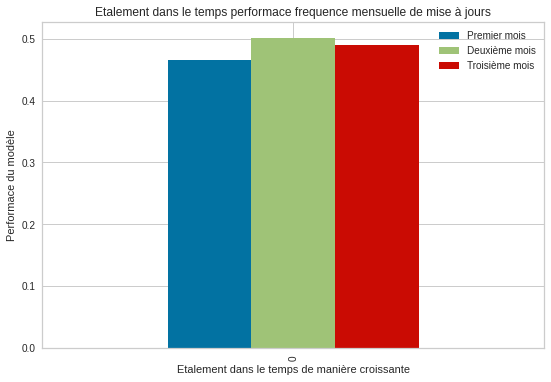

In [ ]:
FM.plot(kind='bar')
plt.xlabel('Etalement dans le temps de manière croissante')
plt.ylabel('Performace du modèle')
plt.legend()
plt.title('Etalement dans le temps performace frequence mensuelle de mise à jours')
plt.show()

### CONCLUSION SUR LA FREQUENCE MENSUELLE

Pour une mise à jours mensuelle on constate que l'étalement dans le temps sur une plage de 3 mois récente de manières croissante, à l'aire de stabiliser la performance de la segmentation client avec une valeur max d'environ 0,5.

### FREQUENCE TRIMESTRIELLE

Je vais effectué une analyse des performances de la segmentation des 3 derniers trimestre dans le temps 

**Le premier trimestre**

In [ ]:
ft1 = (data_M['Date_dernier_achat'] > '2018-01-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-04-17 17:30:18')

In [ ]:
data_ft1 = data_M.loc[ft1]

In [ ]:
data_ft1.shape

(20385, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_ft1[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_ft1[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_ft1 = scaled_features.join(df_cat)

In [ ]:
df_ft1 = pd.get_dummies(df_ft1, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
t1 = KMeans(2).fit(df_ft1)

In [ ]:
TP1 = silhouette_score(df_ft1, t1.labels_, metric='sqeuclidean')

**Le 2ème trimestre**

In [ ]:
ft2 = (data_M['Date_dernier_achat'] > '2018-04-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-07-17 17:30:18')

In [ ]:
data_ft2 = data_M.loc[ft2]

In [ ]:
data_ft2.shape

(18556, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_ft2[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_ft2[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_ft2 = scaled_features.join(df_cat)

In [ ]:
df_ft2 = pd.get_dummies(df_ft2, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
t2 = KMeans(2).fit(df_ft2)

In [ ]:
TP2 = silhouette_score(df_ft2, t2.labels_, metric='sqeuclidean')

**Le 3ème trimestre**

In [ ]:
ft3 = (data_M['Date_dernier_achat'] > '2018-07-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-10-17 17:30:18')

In [ ]:
data_ft3 = data_M.loc[ft3]

In [ ]:
data_ft3.shape

(9960, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_ft3[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_ft3[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_ft3 = scaled_features.join(df_cat)

In [ ]:
df_ft3 = pd.get_dummies(df_ft3, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
t3 = KMeans(2).fit(df_ft3)

In [ ]:
TP3 = silhouette_score(df_ft3, t3.labels_, metric='sqeuclidean')

#### CREATION TABLEAU ET GRAPHIQUE ETALEMENT DANS LE TEMPS (Frèquence trimestrielle)

In [ ]:
T = {'Premier trimestre':[TP1], 'Deuxième trimestre':[TP2], 'Troisième trimestre':[TP3]
    
}

In [ ]:
TM = pd.DataFrame(data=T)

In [ ]:
TM

,Premier trimestre,Deuxième trimestre,Troisième trimestre
0,0.330044,0.40677,0.494496


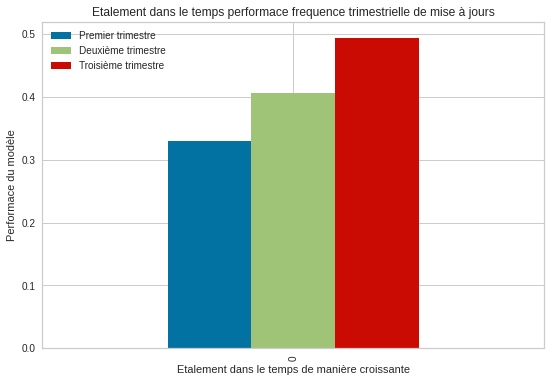

In [ ]:
TM.plot(kind='bar')
plt.xlabel('Etalement dans le temps de manière croissante')
plt.ylabel('Performace du modèle')
plt.legend()
plt.title('Etalement dans le temps performace frequence trimestrielle de mise à jours')
plt.show()

### CONCLUSION SUR LA FREQUENCE TRIMISTRIELLE

Pour une mise à jours trimsetrielle on constate que l'étalement dans le temps sur une plage de 9 mois récent de manières croissante, a tendance à augmenter la performance de la segmentation client avec une valeur max de 0,49. 

### FREQUENCE SEMESTRIELLE

Je vais effectué une analyse des performances de la segmentation des 3 derniers semestre dans le temps 

**Le premier semestre**

In [ ]:
fs1 = (data_M['Date_dernier_achat'] > '2017-04-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2017-10-17 17:30:18')

In [ ]:
data_fs1 = data_M.loc[fs1]

In [ ]:
data_fs1.shape

(22106, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fs1[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fs1[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fs1 = scaled_features.join(df_cat)

In [ ]:
df_fs1 = pd.get_dummies(df_fs1, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
s1 = KMeans(2).fit(df_fs1)

In [ ]:
SP1 = silhouette_score(df_fs1, s1.labels_, metric='sqeuclidean')

**Le 2ème semestre**

In [ ]:
fs2 = (data_M['Date_dernier_achat'] > '2017-10-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-04-17 17:30:18')

In [ ]:
data_fs2 = data_M.loc[fs2]

In [ ]:
data_fs2.shape

(39029, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fs2[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fs2[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fs2 = scaled_features.join(df_cat)

In [ ]:
df_fs2 = pd.get_dummies(df_fs2, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
s2 = KMeans(2).fit(df_fs2)

In [ ]:
SP2 = silhouette_score(df_fs2, s2.labels_, metric='sqeuclidean')

**Le 3ème mois**

In [ ]:
fs3 = (data_M['Date_dernier_achat'] > '2018-04-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-10-17 17:30:18')

In [ ]:
data_fs3 = data_M.loc[fs3]

In [ ]:
data_fs3.shape

(28516, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fs3[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fs3[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fs3 = scaled_features.join(df_cat)

In [ ]:
df_fs3 = pd.get_dummies(df_fs3, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
s3 = KMeans(2).fit(df_fs3)

In [ ]:
SP3 = silhouette_score(df_fs3, s3.labels_, metric='sqeuclidean')

#### CREATION TABLEAU ET GRAPHIQUE ETALEMENT DANS LE TEMPS (Frèquence semestrielle)

In [ ]:
S = {'Premier semestre':[SP1], 'Deuxième semestre':[SP2], 'Troisième semestre':[SP3]
    
}

In [ ]:
SM = pd.DataFrame(data=S)

In [ ]:
SM

,Premier semestre,Deuxième semestre,Troisième semestre
0,0.393693,0.337381,0.404493


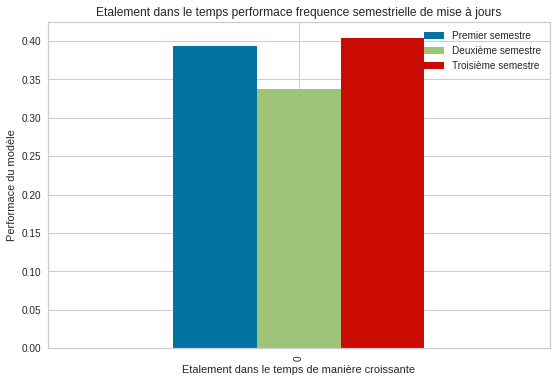

In [ ]:
SM.plot(kind='bar')
plt.xlabel('Etalement dans le temps de manière croissante')
plt.ylabel('Performace du modèle')
plt.legend()
plt.title('Etalement dans le temps performace frequence semestrielle de mise à jours')
plt.show()

### CONCLUSION SUR LA FREQUENCE SEMESTRIELLE

Pour une mise à jours semestrielle on constate que l'étalement dans le temps sur une plage de 18 mois récent de manières croissante, a tendance à fluctuer la performance de la segmentation client avec une valeur max de 0,40. 

### FREQUENCE ANNUELLE

Je vais effectué une analyse des performances de la segmentation des 2 derniers années dans le temps 

**La premiére année**

In [ ]:
fa1 = (data_M['Date_dernier_achat'] > '2016-10-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2017-10-17 17:30:18')

In [ ]:
data_fa1 = data_M.loc[fa1]

In [ ]:
data_fa1.shape

(28236, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fa1[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fa1[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fa1 = scaled_features.join(df_cat)

In [ ]:
df_fa1 = pd.get_dummies(df_fa1, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
a1 = KMeans(2).fit(df_fa1)

In [ ]:
AP1 = silhouette_score(df_fa1, a1.labels_, metric='sqeuclidean')

**La 2ème année**

In [ ]:
fa2 = (data_M['Date_dernier_achat'] > '2017-10-17 17:30:18') & (data_M['Date_dernier_achat'] <= '2018-10-17 17:30:18')

In [ ]:
data_fa2 = data_M.loc[fa2]

In [ ]:
data_fa2.shape

(67545, 25)

#### Préparer le jeu de données

###### Extraire les variables numérique

In [ ]:
val_num = ['Nb_pdts', 'Mont_max_achats',	'Mont_moy_achats',	'Note_Moy_Com',	'Delai_moy_dernier_achat',	'Delai_Moy_Livraison',	'Heure_achat_moy',
          'Jour_achat_moy',	'Note_facil_pai_moy',	'Latitude',	'Longitude']

In [ ]:
df_num = data_fa2[val_num]

###### Extraire les variables catégorique

In [ ]:
val_cat = ['Cat_prod',	'Type_paiement']

In [ ]:
df_cat = data_fa2[val_cat]

###### Standardiser les données numerique

In [ ]:
scaler = StandardScaler().fit(df_num.values)

In [ ]:
features = scaler.transform(df_num.values)

In [ ]:
scaled_features = pd.DataFrame(features, columns = val_num)

###### Encodage à chaud

In [ ]:
df_fa2 = scaled_features.join(df_cat)

In [ ]:
df_fa2 = pd.get_dummies(df_fa2, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

###### Evaluer la performance

In [ ]:
a2 = KMeans(2).fit(df_fa2)

In [ ]:
AP2 = silhouette_score(df_fa2, a2.labels_, metric='sqeuclidean')

#### CREATION TABLEAU ET GRAPHIQUE ETALEMENT DANS LE TEMPS (Frèquence annuelle)

In [ ]:
A = {'Premier année':[AP1], 'Deuxième année':[AP2]
    
}

In [ ]:
AM = pd.DataFrame(data=A)

In [ ]:
AM

,Premier année,Deuxième année
0,0.407999,0.309114


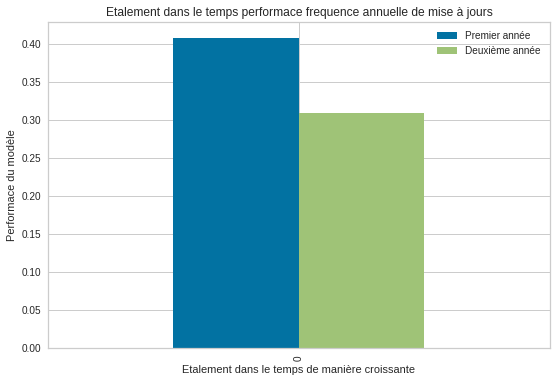

In [ ]:
AM.plot(kind='bar')
plt.xlabel('Etalement dans le temps de manière croissante')
plt.ylabel('Performace du modèle')
plt.legend()
plt.title('Etalement dans le temps performace frequence annuelle de mise à jours')
plt.show()

### CONCLUSION SUR LA FREQUENCE ANNUELLE

Pour une mise à jours annuelle on constate que l'étalement dans le temps sur une plage de 24 mois qui correspond à la taille de mon jeu de données de manières croissante, a tendance à baisser la performance de la segmentation client avec une valeur max de 0,40.



### CONCLUSION SUR LA FREQUENCE DE MISE A JOUR CHOISIE

Pour conclure sur les résultats, je choisirai la frèquence de mise à jours mensuelle, car c'est le plus stable avec la meilleur performance.

## CONCLUSION GENERALE

Pour conclure sur mon projet 5, ce qui ressort tout d'abord de ma segmentation RFM est que 3 types de comportements représentent à eux seules près de 100% du chiffre d'affaire, ensuite par l'intermédiaire du KMeans 1/4 des clients représentent à eux seules pas loin de 100% du chiffre d'affaire et dans le cadre du devis de contrat de maintenance, il faudra intégrés une mise à jours de la segmentation clients tous les mois. De plus les pistes d'améliorations serait les suivante:
- Fidèliser le plus de clients par des actions marketing,
- Augmenter le nombre de diversité de produit de la famille'home',
- Etablir une plateforme logistique à proximité de Sao Paulo qui correspond au clients fidèle qui achète le plus,
- Prèvoir des offres promotionnelles soi le mardi ou mercredi en début d'après midi afin d'augmenter les ventes de produits,
- Et établir un partenariat avec une banque de crèdit à la consommation, afin de facilité le paiement des clients.